# Linear Elasticity in a multipatch domain


In [91]:
%pylab inline
import scipy
import itertools

from pyiga import bspline, assemble, vform, geometry, vis, solvers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# assemble matrix
from scipy.sparse import coo_matrix, block_diag, bmat

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\MHeig\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['bmat', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [92]:
p = 3   # spline degree 
n_el = (50, 10)   # number of elements in y/x direction, isotropic material
#n_el = (50, 20)   # number of elements in y/x direction
# displacement space: degree p,   continuity p-1
kvs = tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=1) for n in n_el) # or : mult=2
m_u = tuple(kv.numdofs for kv in kvs)

In [93]:
# define geometry
# define geometry
geos = [
    geometry.quarter_annulus(),
    geometry.quarter_annulus().rotate_2d(3*pi/2),
    geometry.quarter_annulus().rotate_2d(pi),
    geometry.quarter_annulus().rotate_2d(pi/2)
]

patches = [(kvs, g) for g in geos]

# Here we auto-detect the interfaces between the patches.
# It is also possible to join them manually using
# MP.join_boundaries(...) followed by MP.finalize().
MP = assemble.Multipatch(patches, automatch=True)

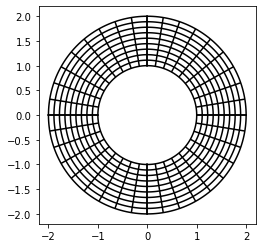

In [94]:
for g in geos:
    vis.plot_geo(g)
axis('scaled');

In [95]:
# rubber, Lamé-coeff.
Mu = 0.003 # [GPa]
Lam = 0.00028416 #  [GPa] (under ass. ny=0.48, almost incompressible)

In [96]:
def A11_vf(dim):
    from pyiga.vform import VForm, grad, inner, div, dx, Dx
    vf = VForm(dim)
    u, v = vf.basisfuns()
    
    grad_uv= inner(grad(u), grad(v))
    div_11 = Dx(u,0) * Dx(v,0)
    
    vf.add(Mu * ( grad_uv +  div_11) * dx  + Lam *div_11 * dx )
    return vf

def A12_vf(dim):
    from pyiga.vform import VForm, grad, inner, div, dx, Dx
    vf = VForm(dim)
    u, v = vf.basisfuns()

    grad_uv= inner(grad(u), grad(v))
    div_12 = Dx(u,1) * Dx(v,0)
    div_21 = Dx(u,0) * Dx(v,1)
    
    vf.add(Mu * div_21 * dx  + Lam *div_12 * dx )
    return vf

           
def A21_vf(dim):
    from pyiga.vform import VForm, grad, inner, div, dx, Dx
    vf = VForm(dim)
    u, v = vf.basisfuns()

    grad_uv= inner(grad(u), grad(v))
    div_12 = Dx(u,1) * Dx(v,0)
    div_21 = Dx(u,0) * Dx(v,1)
    
    vf.add( Mu * div_12 * dx  + Lam *div_21* dx )
    return vf
           
def A22_vf(dim):
    from pyiga.vform import VForm, grad, inner, div, dx, Dx
    vf = VForm(dim)
    u, v = vf.basisfuns()

    grad_uv= inner(grad(u), grad(v))
    div_22 = Dx(u,1) * Dx(v,1)
    
    vf.add(Mu * ( grad_uv +  div_22) * dx  + Lam *div_22 * dx)
    return vf


#A = bmat([[A11, A12], [A21, A22]]) 

In [97]:
# source term f 
def f(x, y): return (0.0)

In [98]:
#Neumann BC
def g_N(x, y): return (-3e-5) # Neumann BC function

def g0(x,y):
    if (x>4).all():
        return -3e-7 # set force at distal end only
    else:
        return 0
    
def g(x,y):
    #print(x)
    if isinstance(x,numpy.float64):
        return (g0(x,y))
    #print (([g0(xi,0) for xi in np.nditer(x)]))
    return ([g0(xi,0) for xi in np.nditer(x)])


# set inhom. Neumann cond. on distal end, hom. NBC elsewhere
neu_data = [
    #(0, 'top', g),
    #(0,'right', g_N),
    #(1,'right', g_N),
    #(2,'right', g_N) 
    (3,'right', g_N) 
]

MP = assemble.Multipatch(patches, {'N':neu_data}, automatch=True) # physical!
#MP = assemble.Multipatch(patches, automatch=True) # without Neumann! 

In [99]:
#A, rhs, N = MP.assemble_system(linelast_vf(2), vform.L2functional_vf(2, physical=True), f=f)

A11, rhs1, nbc11 = MP.assemble_system(A11_vf(2), vform.L2functional_vf(2, physical=True), f=f)
A12, rhs12, nbc2 = MP.assemble_system(A12_vf(2), vform.L2functional_vf(2, physical=True), f=f) 
A21, rhs21, nbc21 = MP.assemble_system(A21_vf(2), vform.L2functional_vf(2, physical=True), f=f) 
A22, rhs2, nbc22 = MP.assemble_system(A22_vf(2), vform.L2functional_vf(2, physical=True), f=f)

A = bmat([[A11, A12], [A21, A22]])

print(shape(A11))
print(shape(A))


(2704, 2704)
(5408, 5408)


In [100]:
# define Dirichlet boundary conditions 
# Dirichlet boundary function g
def g_zero(x, y): return (0.0)

# set up Dirichlet boundary conditions
bcs = MP.compute_dirichlet_bcs([
    (1, 'right', g_zero),
    #(1, 'top', g_zero), 
    #(2, 'right', g_zero), 
    #(3, 'top', g_zero)
])


In [101]:
print(shape(bcs))
#print(bcs)

bcs2= bcs[0]+MP.numdofs 
bcs12= np.append(bcs[0],bcs2)
bcs22 = np.append(bcs[1],bcs[1])

bc= [bcs12, bcs22]
print(shape(bc))
#print(bc)


(2, 53)
(2, 106)


In [102]:
rhs= np.hstack((rhs1, rhs2))
print(shape(rhs))
#print(rhs)

nbc= np.hstack((nbc22, np.zeros(shape(nbc11)))) ## x-dir####in y-dir
print(shape(nbc))
print(nbc)


(5408,)
(5408,)
[0. 0. 0. ... 0. 0. 0.]


In [103]:
# set up and solve linear system
LS = assemble.RestrictedLinearSystem(A, rhs +nbc, bc) #
u = LS.complete(solvers.make_solver(LS.A, spd=True).dot(LS.b))

#print(shape(u))
print(u)

[-0.01773598 -0.0176744  -0.0177554  ... -0.15088131 -0.15543307
 -0.15794023]


In [104]:
print(MP.numdofs) # global dofs (=all dofs interface dofs,i.e. 2x16-4 = 28)
print(2*MP.numdofs) 

u1 = u[:MP.numdofs] 
u2 = u[MP.numdofs:2*MP.numdofs]

2704
5408


In [105]:
# restrict solution to each individual patch
u1_funcs = [geometry.BSplineFunc(kvs, MP.global_to_patch(p) @ u1)
           for p in range(len(patches))]
u2_funcs = [geometry.BSplineFunc(kvs, MP.global_to_patch(p) @ u2)
           for p in range(len(patches))]

In [106]:
def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

# evaluate displacement and "pressure" over a grid in the parameter domain
xgrid = linspace(0, 1, 10)
xygrid = (xgrid, xgrid)

#print(len(xgrid))

In [107]:
#figsize(8,6)

#for (u1_func, (kvs, geo)) in zip(u1_funcs, patches):
    #print(u_func)
#    vis.plot_field((u1_func), geo, vmin=0, vmax=1.5e-1)
#axis('scaled')
#colorbar();

0
1
2
3


(-2.130653028149687, 2.0, -2.0, 2.2)

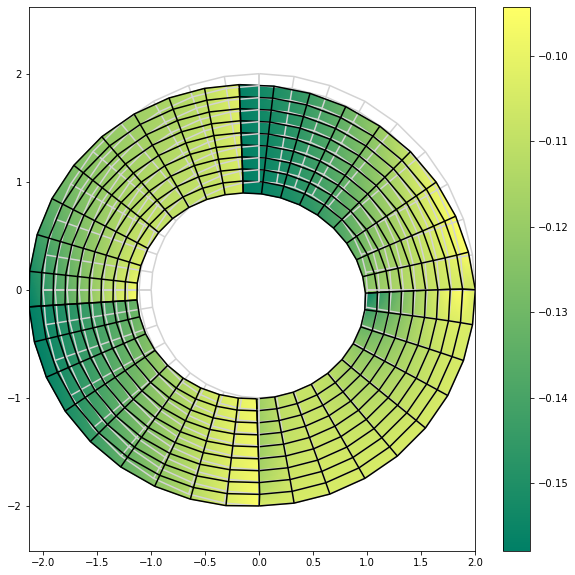

In [108]:
## nbc in parameter domain

figsize(10,10)
fig, ax = plt.subplots()
k=0
d=[]
len_xgrid= len(xgrid)
#dis=np.empty([4,len_xgrid,2])

for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches): #u_funcs 
        
    print(k)
    dis1 = u1_func.grid_eval(xygrid) #x-value
    dis2 = u2_func.grid_eval(xygrid) #y-value
    #print('dis1= ', dis1)
    #print([dis1,dis2])
    #dis = np.stack((dis1,dis2), axis=-1)
    #print('dis=', dis)
    #d.append(dis)
    

    k+=1
    G = geo.grid_eval(xygrid)
    plot_grid(G[...,0], G[...,1], ax=ax, color="lightgrey")
    plot_grid(G[...,0]+dis1, G[...,1]+dis2,ax=ax, color="black")
    pcolormesh(G[...,0]+dis1, G[...,1]+dis2, dis2 , cmap='summer', shading='gouraud');
    
    #print(shape(dis1))
    #print('dis1= ', dis1)
    #print('dis2= ', dis2)

colorbar();
axis('equal')